# Loan Default Prediction Analysis

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## 1. Data Collection

In [2]:
# Load datasets
train_dataset = pd.read_csv('dataset/Training Data.csv')
test_dataset  = pd.read_csv('dataset/Test Data.csv')

# Standardize test set column names
test_dataset.rename(columns={
    'ID': 'Id',
    'risk_flag': 'Risk_Flag'
}, inplace=True)

We’re reading in the training and test CSV files and making sure the test set’s key columns match the naming convention we’ll use throughout the analysis.

## 2. Data Visualization

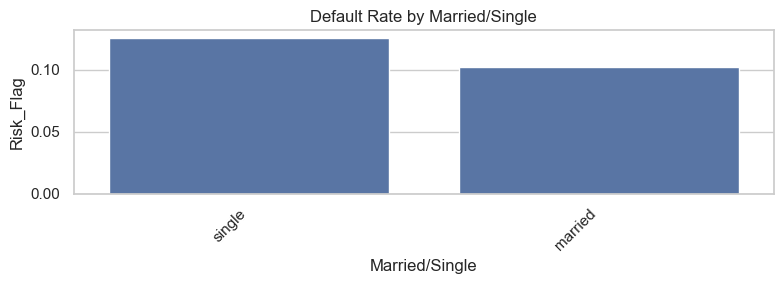

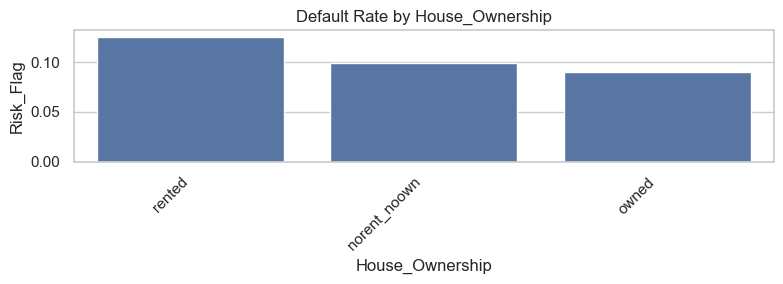

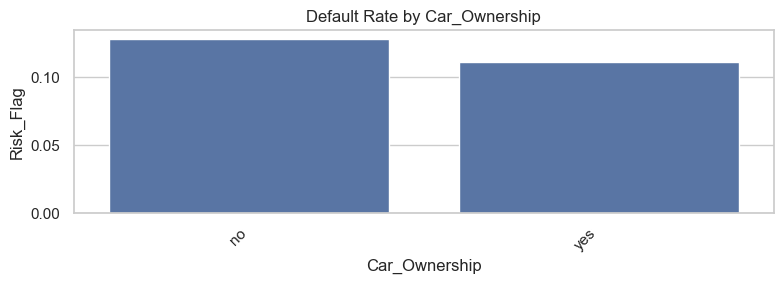

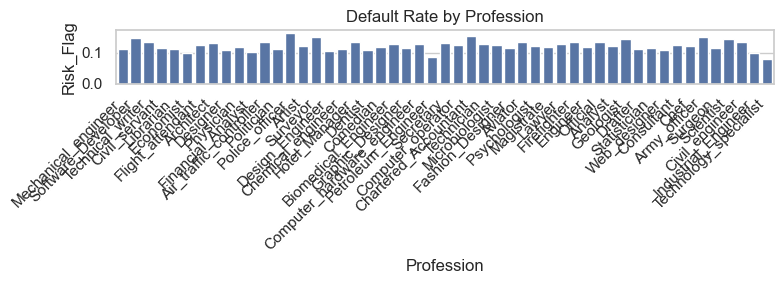

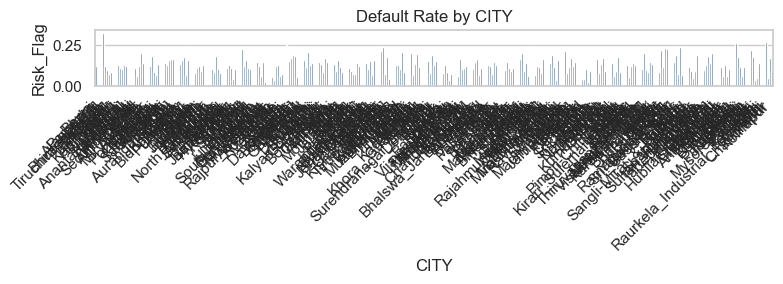

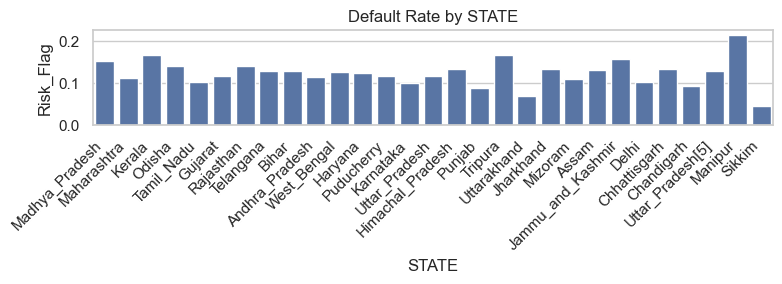

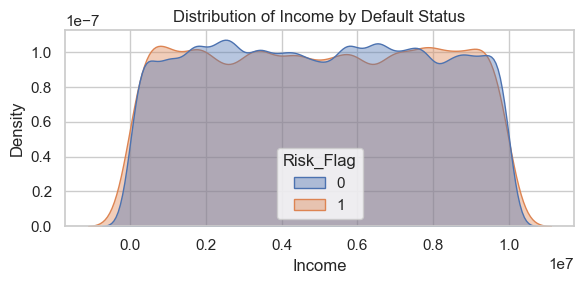

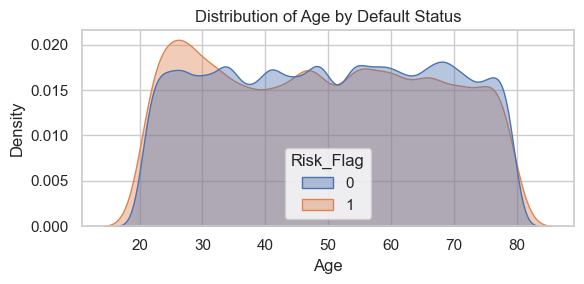

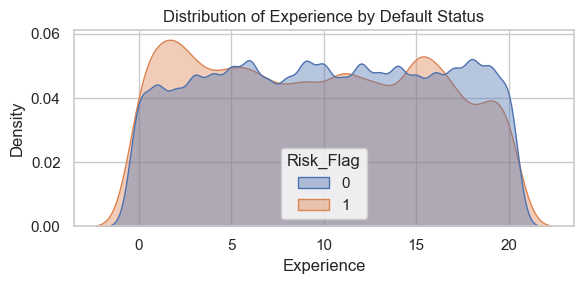

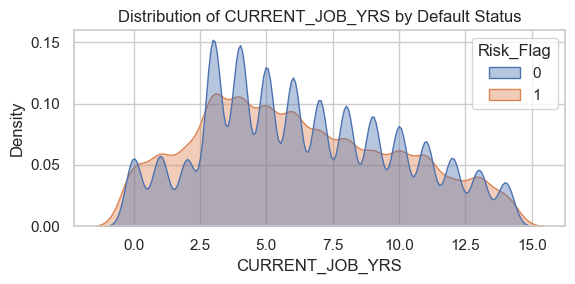

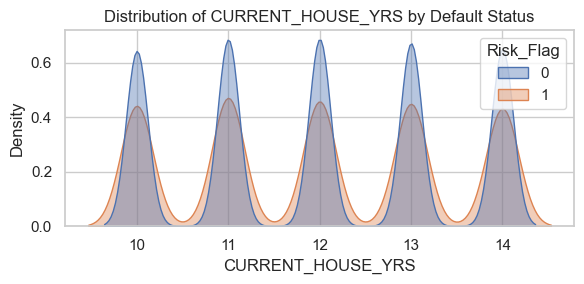

In [3]:
sns.set(style="whitegrid")

df = train_dataset.copy()

# Categorical features: barplots of mean risk_flag
categorical_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']

for col in categorical_cols:
    plt.figure(figsize=(8, 3))
    sns.barplot(data=df, x=col, y='Risk_Flag', errorbar=None)
    plt.title(f"Default Rate by {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Numeric features: KDE plots
numeric_cols = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=df, x=col, hue='Risk_Flag', fill=True, common_norm=False, alpha=0.4)
    plt.title(f"Distribution of {col} by Default Status")
    plt.tight_layout()
    plt.show()


Bar plots (for categorical features) display the mean risk_flag per category, effectively showing the default rate.
Example: If single borrowers have a higher average risk_flag, they default more often.
KDE plots (for numerical features) visualize the distribution of each feature split by default status.
Example: You can observe whether defaulters tend to have lower income or less job experience.

## 3. Data Preprocessing

In [4]:
# 3. Data preprocessing: dedupe, normalize, encode non‑numeric


# 3.1  Drop duplicates & normalize column names
for df in (train_dataset, test_dataset):
    df.drop_duplicates(inplace=True)
    df.columns = df.columns.str.strip().str.lower()

train_dataset.drop(columns='id', errors='ignore', inplace=True)
test_dataset.drop(columns='id', errors='ignore', inplace=True)

# 3.2  Drop the ID column (not a feature)
train_dataset.drop(columns='id', errors='ignore', inplace=True)
test_dataset.drop(columns='id', errors='ignore', inplace=True)

# 3.3  Encoding Non Numeric Features
for df in (train_dataset, test_dataset):
    df['married'] = df['married/single'].map({'single': 0, 'married': 1})
    df['house_owned'] = df['house_ownership'].map({'rented': 0, 'owned': 1, 'norent_noown': 2})
    df['has_car'] = df['car_ownership'].map({'no': 0, 'yes': 1})
    df.drop(columns=['married/single', 'house_ownership', 'car_ownership'],inplace=True, errors='ignore')

# 3.4  Target‑encode high‑cardinality categories
def oof_target_encode_overwrite(train_df, test_df, col, target='risk_flag', n_splits=5):
    tr = train_df.copy()
    te = test_df.copy()
    oof = pd.Series(index=tr.index, dtype=float)
    kf  = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(tr):
        means = tr.iloc[train_idx].groupby(col)[target].mean()
        oof.iloc[val_idx] = tr.iloc[val_idx][col].map(means)
    global_mean = tr[target].mean()
    oof.fillna(global_mean, inplace=True)
    tr[col] = oof
    te[col] = te[col].map(means).fillna(global_mean)
    return tr, te

for col in ['profession', 'city', 'state']:
    train_dataset, test_dataset = oof_target_encode_overwrite(train_dataset, test_dataset, col)

train_dataset and test_dataset are now ready for data analysis.

## 4. Data Analysis

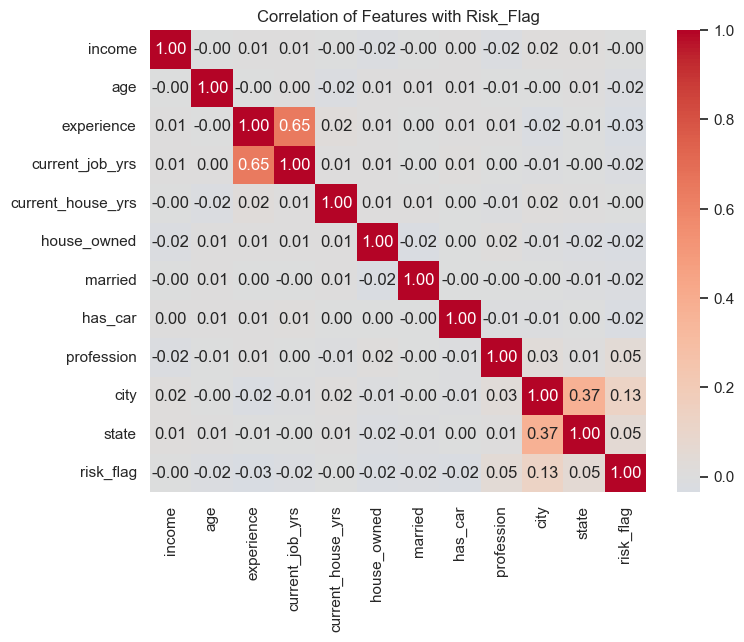

Mutual Information (features):
 income               0.158937
current_house_yrs    0.009094
city                 0.008959
current_job_yrs      0.004997
experience           0.003644
age                  0.002234
state                0.001678
profession           0.001033
house_owned          0.000391
has_car              0.000294
married              0.000233
dtype: float64


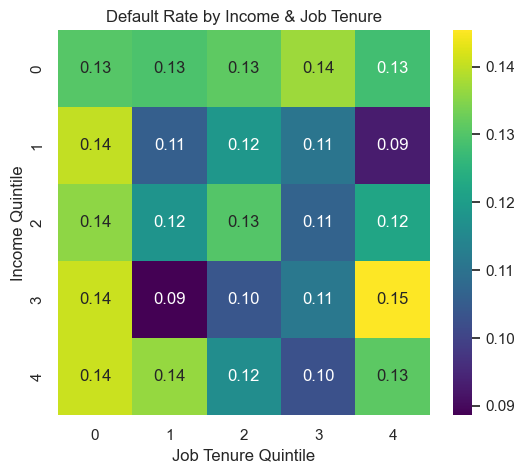

In [5]:
df = train_dataset.copy()

# 4.1) Feature vs. Target Correlation
raw_feats = ['income', 'age', 'experience', 'current_job_yrs', 'current_house_yrs',
             'house_owned', 'married', 'has_car', 'profession', 'city', 'state']
corr = df[raw_feats + ['risk_flag']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation of Features with Risk_Flag')
plt.show()

# 4.2) Mutual Information for Raw Features
X = df[raw_feats]
y = df['risk_flag']
discrete = ['married','house_owned','has_car']
mi = mutual_info_classif(X, y, discrete_features=[c in discrete for c in X.columns], random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information (features):\n", mi_series)

# 4.3) Interaction heatmap: Income × Job Tenure
df['inc_q'] = pd.qcut(df['income'], 5, labels=False)
df['job_q'] = pd.qcut(df['current_job_yrs'], 5, labels=False)
pivot = df.pivot_table(index='inc_q', columns='job_q', values='risk_flag', aggfunc='mean')
plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='viridis')
plt.xlabel('Job Tenure Quintile')
plt.ylabel('Income Quintile')
plt.title('Default Rate by Income & Job Tenure')
plt.show()

Now we'll use these analyses to do some feature engineering on dataset

## 5. Feature Engineering

In [6]:
for df in (train_dataset, test_dataset):
    # 5.1, 5.2 Stability ratios
    df['job_stability'] = df['current_job_yrs'] / (df['experience'] + 1)
    df['residence_stability']= df['current_house_yrs'] * (1 + df['house_owned'])
    # 5.3 Age buckets
    df['age_bucket'] = pd.cut(df['age'], bins=[18,25,35,50,65,100], labels=False)
    df.drop(columns=['age','experience','current_job_yrs','current_house_yrs'], inplace=True, errors='ignore')
    # 5.4 Interaction terms
    df['inc_x_jobstab'] = df['income'] * df['job_stability']
    df['inc_x_profrisk'] = df['income'] * df['profession']

Now the dataset is ready for model development.

## 6. Model Development

In [7]:
# 6.1) Initial 60/20/20 split
X_full = train_dataset.drop(columns='risk_flag')
y_full = train_dataset['risk_flag']

# First, we carve out 20% for final test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)
# Then we split the remaining 80% into 75% train / 25% val => net 60/20/20
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape[0]} rows")
print(f"Val: {X_val.shape[0]} rows")
print(f"Test: {X_test.shape[0]} rows")

Train: 151200 rows
Val: 50400 rows
Test: 50400 rows


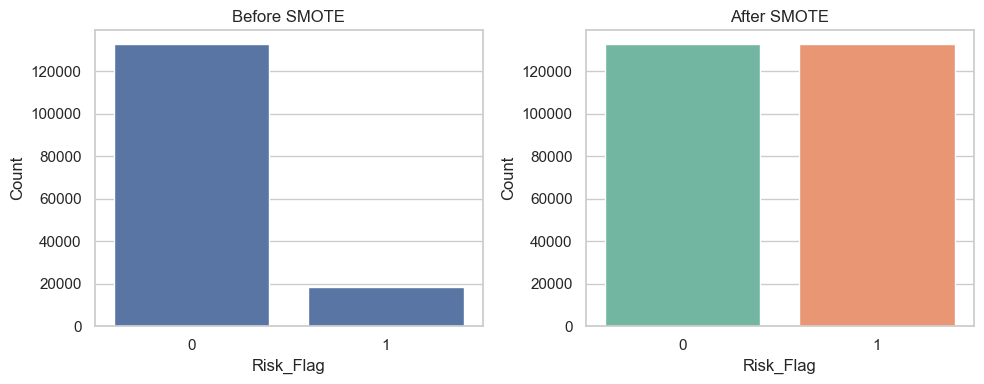

In [8]:
# 6.2) Plot original class distribution
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Risk_Flag')
axes[0].set_ylabel('Count')

# 6.3) Apply SMOTE to the TRAINING data only
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# 6.4) Plot resampled class distribution
sns.countplot(x=y_res, ax=axes[1], palette='Set2')
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Risk_Flag')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [11]:
# 6.5) Define a helper to plot validation curve on our fixed validation set
def plot_validation_curve(model_cls, param_name, param_range, X_train, y_train, X_val, y_val, **fixed_params):
    train_aucs, val_aucs = [], []

    for val in param_range:
        params = {param_name: val, **fixed_params}
        model = model_cls(**params)
        model.fit(X_train, y_train)

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]

        train_aucs.append(roc_auc_score(y_train, train_probs))
        val_aucs.append(roc_auc_score(y_val, val_probs))

    plt.figure(figsize=(6,4))
    plt.plot(param_range, train_aucs, marker='o', label='Train AUC')
    plt.plot(param_range, val_aucs, marker='o', label='Val   AUC')
    plt.xlabel(param_name)
    plt.ylabel('AUC')
    plt.title(f'{model_cls.__name__} - {param_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

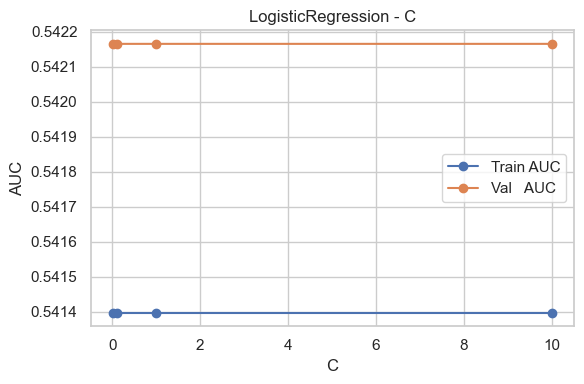

In [12]:
# 6.6) Sweep over key parameters on Logistic Regression using plot_validation_curve
plot_validation_curve(LogisticRegression, 'C', [0.01, 0.1, 1, 10],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val,
    solver='liblinear', penalty='l2', max_iter=1000, random_state=42)

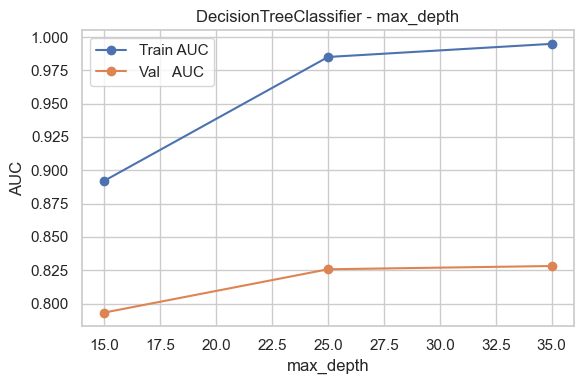

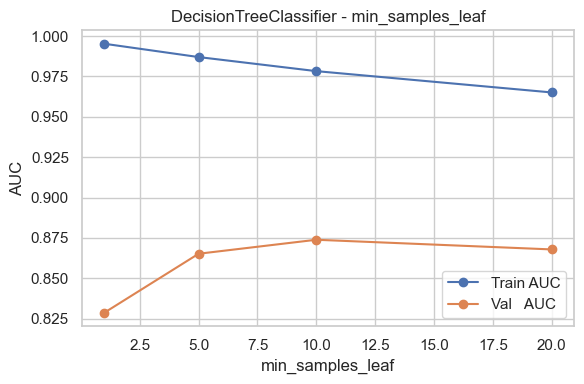

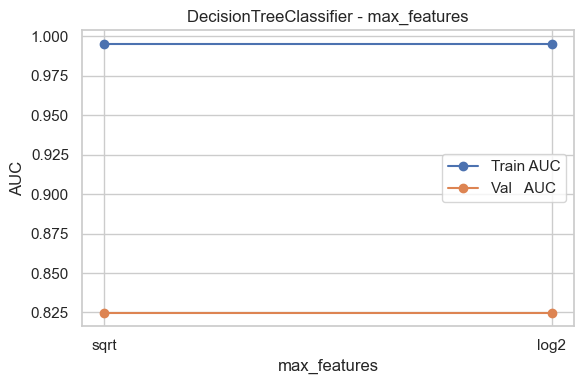

In [13]:
# 6.7) Sweep over key parameters on Decision Tree Classifier using plot_validation_curve
plot_validation_curve(DecisionTreeClassifier, 'max_depth', [15, 25, 35],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42)

plot_validation_curve(DecisionTreeClassifier, 'min_samples_leaf', [1, 5, 10, 20],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42)

plot_validation_curve(DecisionTreeClassifier, 'max_features', ['sqrt', 'log2'],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42)


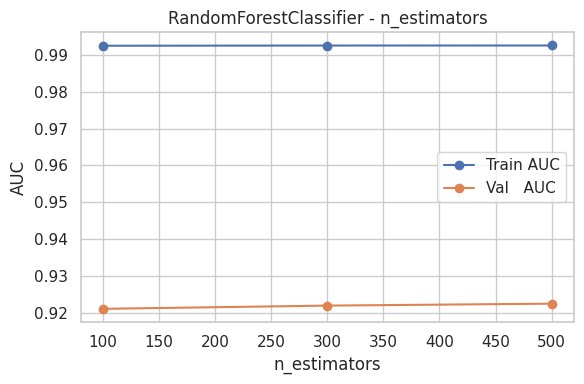

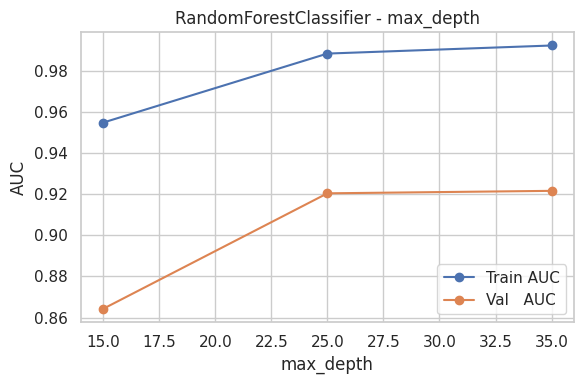

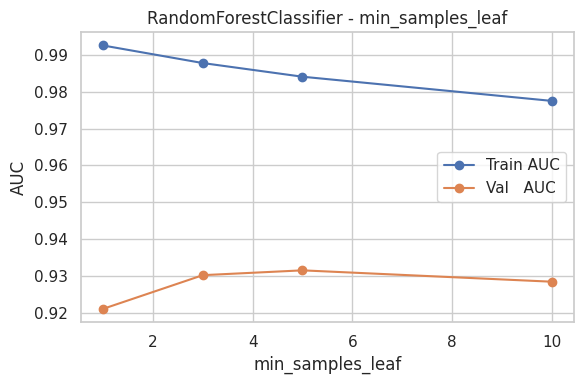

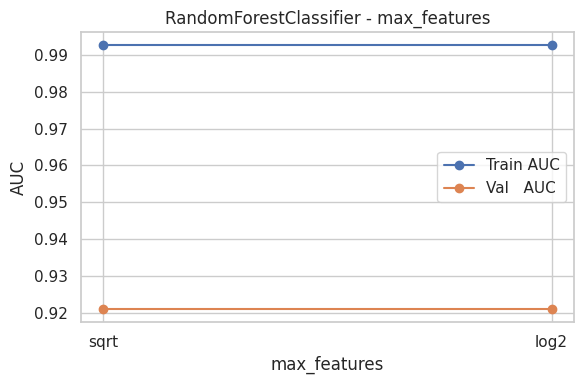

In [34]:
# 6.7) Sweep over key parameters on Random Forest Classifier using plot_validation_curve
plot_validation_curve(RandomForestClassifier, 'n_estimators', [100, 300, 500],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42, n_jobs=-1)

plot_validation_curve(RandomForestClassifier, 'max_depth', [15, 25, 35],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42, n_jobs=-1)

plot_validation_curve(RandomForestClassifier, 'min_samples_leaf', [1, 3, 5, 10],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42, n_jobs=-1)

plot_validation_curve(RandomForestClassifier, 'max_features', ['sqrt', 'log2'],
    X_train=X_res, y_train=y_res, X_val=X_val, y_val=y_val, random_state=42, n_jobs=-1)


In [35]:
# 6.8) Train final model with chosen hyperparameters
best_params = {
    'n_estimators': 300,
    'max_depth': 25,
    'min_samples_leaf': 5,
    'max_features': 'sqrt'
}
final_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
final_rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=25, min_samples_leaf=5, n_estimators=300,
                       n_jobs=-1, random_state=42)

## 7. Model Evaluation and Optimization

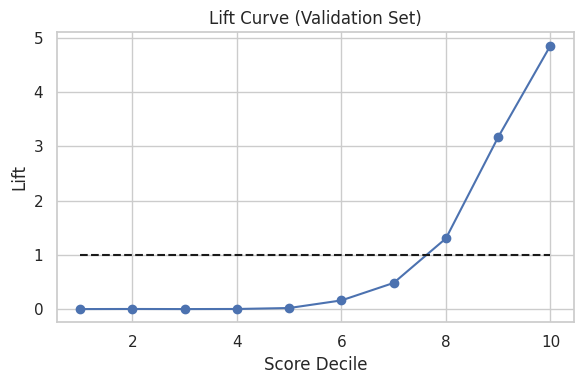

In [38]:
val_probs = final_rf.predict_proba(X_val)[:,1]
def plot_lift(y_true, y_score, n_bins=10):
    df = pd.DataFrame({'y':y_true, 'p':y_score})
    df['decile'] = pd.qcut(df['p'], q=n_bins, labels=False)+1
    lift = df.groupby('decile')['y'].mean() / df['y'].mean()
    plt.figure(figsize=(6,4))
    plt.plot(lift.index, lift.values, marker='o')
    plt.hlines(1, 1, n_bins, colors='k', linestyles='--')
    plt.xlabel('Score Decile')
    plt.ylabel('Lift')
    plt.title('Lift Curve (Validation Set)')
    plt.tight_layout()
    plt.show()

plot_lift(y_val, val_probs)

## 8. Results

In [37]:
train_preds = final_rf.predict(X_res)
train_probs = final_rf.predict_proba(X_res)[:,1]

val_preds   = final_rf.predict(X_val)
val_probs   = final_rf.predict_proba(X_val)[:,1]

test_preds  = final_rf.predict(X_test)
test_probs  = final_rf.predict_proba(X_test)[:,1]

print("=== Training Set ===")
print(classification_report(y_res, train_preds))
print("Train AUC:", round(roc_auc_score(y_res, train_probs),4))
print()

print("=== Validation Set ===")
print(classification_report(y_val, val_preds))
print("Validation AUC:", round(roc_auc_score(y_val, val_probs),4))
print()

print("=== Test Set ===")
print(classification_report(y_test, test_preds))
print("Test AUC:", round(roc_auc_score(y_test, test_probs),4))


=== Training Set ===
              precision    recall  f1-score   support

           0       0.97      0.92      0.95    132602
           1       0.93      0.98      0.95    132602

    accuracy                           0.95    265204
   macro avg       0.95      0.95      0.95    265204
weighted avg       0.95      0.95      0.95    265204

Train AUC: 0.9815

=== Validation Set ===
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     44201
           1       0.53      0.74      0.62      6199

    accuracy                           0.89     50400
   macro avg       0.74      0.82      0.77     50400
weighted avg       0.91      0.89      0.89     50400

Validation AUC: 0.9271

=== Test Set ===
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     44201
           1       0.52      0.73      0.61      6199

    accuracy                           0.88     50400
   macro avg       0.74 